<a href="https://colab.research.google.com/github/RiceWater/New-Thesis-KFold-3CLS/blob/No-Building/Kaggle_3CLS_No_Building.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip list

Package                          Version
-------------------------------- ---------------------
absl-py                          1.4.0
aiohttp                          3.9.3
aiosignal                        1.3.1
alabaster                        0.7.16
albumentations                   1.3.1
altair                           4.2.2
annotated-types                  0.6.0
anyio                            3.7.1
appdirs                          1.4.4
argon2-cffi                      23.1.0
argon2-cffi-bindings             21.2.0
array_record                     0.5.1
arviz                            0.15.1
astropy                          5.3.4
astunparse                       1.6.3
async-timeout                    4.0.3
atpublic                         4.1.0
attrs                            23.2.0
audioread                        3.0.1
autograd                         1.6.2
Babel                            2.14.0
backcall                         0.2.0
beautifulsoup4                   4.12.3


In [2]:
!pip uninstall jax -y

Found existing installation: jax 0.4.26
Uninstalling jax-0.4.26:
  Successfully uninstalled jax-0.4.26


In [3]:
!pip install tensorflow==2.15.0

In [4]:
!python --version

Python 3.10.12


In [5]:
!pip install image_to_numpy==1.0.0

  Preparing metadata (setup.py) ... done
  Created wheel for image_to_numpy: filename=image_to_numpy-1.0.0-py3-none-any.whl size=3456 sha256=99b437fa6c2377d693b31a2109795c57322b5a61aa93ce4a792878ec849812b6
  Stored in directory: /root/.cache/pip/wheels/4c/e5/7e/f10f47129bb75abc8cd52a8abbff926b4a6121990f926cfe6d
Successfully built image_to_numpy


In [6]:
!pip install neptune==1.9.1 neptune-tensorflow-keras==2.2.2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 495.5/495.5 kB 8.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 11.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.3/139.3 kB 1.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.1/12.1 MB 39.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.2/82.2 kB 12.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.9/63.9 kB 8.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.9/137.9 kB 20.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 8.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.4/66.4 kB 8.7 MB/s eta 0:00:00
  Created wheel for bravado-core: filename=bravado_core-6.1.1-py2.py3-none-any.whl size=67672 sha256=7976c2f37325128a0a3159bfece61d8ea13bac4232fbf2321b505648d0fb253b
  Stored in directory: /root/.cache/pip/wheels/42/35/4a/44ec4

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
import tqdm
import os
import cv2
import imghdr
import image_to_numpy
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from datetime import datetime
import itertools
from numpy.random import default_rng

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import RandomFlip, RandomRotation, RandomContrast, RandomBrightness, Rescaling, Resizing
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, ReLU
from tensorflow.keras.metrics import F1Score, Precision, Recall, CategoricalAccuracy
from tensorboard.plugins.hparams import api as hp
import sklearn
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.model_selection import StratifiedKFold

from time import perf_counter
import math

import neptune
from neptune.integrations.tensorflow_keras import NeptuneCallback

In [9]:

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/content/drive/MyDrive/Chua_Thesis/4-600-Dataset'):
    print(os.path.join(dirname))




/content/drive/MyDrive/Chua_Thesis/4-600-Dataset
/content/drive/MyDrive/Chua_Thesis/4-600-Dataset/Road
/content/drive/MyDrive/Chua_Thesis/4-600-Dataset/Vehicle
/content/drive/MyDrive/Chua_Thesis/4-600-Dataset/Plant
/content/drive/MyDrive/Chua_Thesis/4-600-Dataset/Building


In [10]:
def make_model(params):
    model = Sequential()
    model.add(RandomFlip(mode='horizontal', seed=1, input_shape=(256,256,3)))
    model.add(RandomRotation(factor=0.2, seed=1))

    model.add(Conv2D(input_shape=(256,256,3), filters=32, kernel_size=(3,3), padding="same"))
    model.add(Conv2D(filters=32, kernel_size=(3,3), padding="same"))
    model.add(BatchNormalization(epsilon=0.0001))
    model.add(ReLU())
    model.add(MaxPooling2D())

    model.add(Conv2D(filters=64, kernel_size=(3,3), padding="same"))
    model.add(Conv2D(filters=64, kernel_size=(3,3), padding="same"))
    model.add(BatchNormalization(epsilon=0.0001))
    model.add(ReLU())
    model.add(MaxPooling2D())

    model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same"))
    model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same"))
    model.add(BatchNormalization(epsilon=0.0001))
    model.add(ReLU())
    model.add(MaxPooling2D())

    model.add(Flatten())
    model.add(Dropout(0.2, seed=1))
    model.add(Dense(units=640,activation="relu"))
    model.add(Dropout(0.2, seed=1))
    model.add(Dense(units=256,activation="relu"))

    model.add(Dense(units=3, activation="softmax"))


    optimizer = tf.keras.optimizers.Adam(
        learning_rate=params["lr"],
    )

    model.compile(optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [11]:
def create_callbacks(counter):
    neptune_cbk = NeptuneCallback(run=run, base_namespace="training")

    cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path + str(counter),
                                                                 monitor='val_loss',
                                                                 mode='auto',
                                                                 save_best_only=True,
                                                                 verbose=1)
    es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                   patience=23,
                                                  )
    reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                                         factor=0.6,
                                                         patience=10,
                                                         min_delta=0.001,
                                                         mode='auto',
                                                         verbose=1)
#     return [reduce_lr, cp_callback, es_callback]
    return [neptune_cbk, reduce_lr, cp_callback, es_callback]

In [12]:
def plot_loss(hist):
    fig = plt.figure(figsize=(3,2))
    plt.plot(hist.history['loss'], color='teal', label='loss')
    plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
    plt.suptitle('Loss')
    plt.legend(loc='upper right')
    plt.show()
    return fig

def plot_acc(hist):
    fig = plt.figure(figsize=(3,2))
    plt.plot(hist.history['accuracy'], color='teal', label='acc')
    plt.plot(hist.history['val_accuracy'], color='orange', label='val_acc')
    plt.suptitle('Accuracy')
    plt.legend(loc='upper left')
    plt.show()
    return fig

def avg_rate(metric_list):
    return sum(metric_list) / len(metric_list)

In [13]:
with tf.device('/gpu:0'):
    labels = ['Plant', 'Vehicle', 'Road']
    X_train = []
    y_train = []
    y_label_idx = []
    image_size = 256
    for i in labels:
        folderPath = os.path.join('/content/drive/MyDrive/Chua_Thesis/4-600-Dataset', i)
        for j in os.listdir(folderPath):
            img = image_to_numpy.load_image_file(os.path.join(folderPath,j))
            img = cv2.resize(img,(image_size, image_size))
            X_train.append(img)
            y_label_idx.append(labels.index(i))

In [14]:
X_train = np.array(X_train)
y_label_idx = np.array(y_label_idx)

X_train_scaled = X_train.astype(np.float32) / 255.0

In [15]:
# seed ensures that the generation are the same from local and kaggle
rng = default_rng(seed=1)

plants_test_idx = rng.choice(np.arange(0,600), size=120, replace=False)
vehicles_test_idx = rng.choice(np.arange(600,1200), size=120, replace=False)
roads_test_idx = rng.choice(np.arange(1200,1800), size=120, replace=False)
total_test_idx = np.concatenate((plants_test_idx, vehicles_test_idx, roads_test_idx), axis=None)
print(total_test_idx[:20])

[273 397 467 471 105 584 208 456  32 573 462 540 261 134 460 229 494 293
 412 515]


In [16]:
def train_test_X(X_train_scaled):
    test_x = X_train_scaled[total_test_idx]
    train_x = np.delete(X_train_scaled, total_test_idx, axis=0)
    return train_x, test_x

def train_test_y(y_label_idx):
    test_y = y_label_idx[total_test_idx]
    train_y = np.delete(y_label_idx, total_test_idx, axis=0)
    return train_y, test_y

In [17]:
train_x, holdout_x = train_test_X(X_train_scaled)
train_y, holdout_y = train_test_y(y_label_idx)

## KFOLD

In [18]:
!mkdir MODEL

In [19]:
!ls ./

drive  MODEL  sample_data


In [20]:
model_name= 'Model 3CLS-NB-4.1.2'
checkpoint_path = f'/content/MODEL/{model_name}/FOLD-'
kfold = StratifiedKFold(n_splits=8, shuffle=True, random_state=1)
project_name='New-Thesis/Kaggle-3Cls-No-Building'

[neptune] [info   ] Neptune initialized. Open in the app: offline/17d54336-c41d-4a09-a573-110bdfc0e81e


[neptune] [warning] NeptuneWarning: The following monitoring options are disabled by default in interactive sessions: 'capture_stdout', 'capture_stderr', 'capture_traceback', and 'capture_hardware_metrics'. To enable them, set each parameter to 'True' when initializing the run. The monitoring will continue until you call run.stop() or the kernel stops. Also note: Your source files can only be tracked if you pass the path(s) to the 'source_code' argument. For help, see the Neptune docs: https://docs.neptune.ai/logging/source_code/


Epoch 1/45
158/158 [==============================] - ETA: 0s - loss: 26.7318 - accuracy: 0.5976
Epoch 1: val_loss improved from inf to 1.44878, saving model to /content/MODEL/Model 3CLS-NB-4.1.2/FOLD-0
158/158 [==============================] - 17s 60ms/step - loss: 26.7318 - accuracy: 0.5976 - val_loss: 1.4488 - val_accuracy: 0.5056 - lr: 0.0015
Epoch 2/45
158/158 [==============================] - ETA: 0s - loss: 2.1296 - accuracy: 0.6595
Epoch 2: val_loss improved from 1.44878 to 1.13539, saving model to /content/MODEL/Model 3CLS-NB-4.1.2/FOLD-0
158/158 [==============================] - 10s 63ms/step - loss: 2.1296 - accuracy: 0.6595 - val_loss: 1.1354 - val_accuracy: 0.7278 - lr: 0.0015
Epoch 3/45
156/158 [============================>.] - ETA: 0s - loss: 0.8670 - accuracy: 0.7155
Epoch 3: val_loss did not improve from 1.13539
158/158 [==============================] - 4s 25ms/step - loss: 0.8681 - accuracy: 0.7151 - val_loss: 1.2338 - val_accuracy: 0.6389 - lr: 0.0015
Epoch 4/45

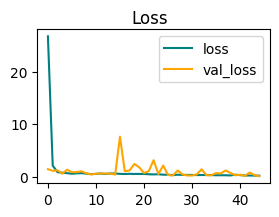

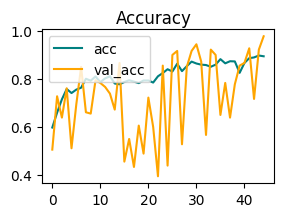

Fold Training Time: 0 hour(s) and 4 mins
Precision: 99.4252860546112  -  Recall: 96.11111283302307
Accuracy: 97.77777791023254
F1Score-P: 98.33333587646484
F1Score-R: 97.4358901977539
F1Score-V: 97.56097412109375
[neptune] [info   ] Shutting down background jobs, please wait a moment...
[neptune] [info   ] Done!
[neptune] [info   ] Neptune initialized. Open in the app: offline/3534d2bd-39e9-4ac0-a465-1278966d110c
Epoch 1/45
157/158 [============================>.] - ETA: 0s - loss: 24.6816 - accuracy: 0.5836
Epoch 1: val_loss improved from inf to 10.08244, saving model to /content/MODEL/Model 3CLS-NB-4.1.2/FOLD-1
158/158 [==============================] - 12s 54ms/step - loss: 24.6292 - accuracy: 0.5833 - val_loss: 10.0824 - val_accuracy: 0.5111 - lr: 0.0015
Epoch 2/45
158/158 [==============================] - ETA: 0s - loss: 1.7167 - accuracy: 0.7397
Epoch 2: val_loss improved from 10.08244 to 0.62819, saving model to /content/MODEL/Model 3CLS-NB-4.1.2/FOLD-1
158/158 [===============

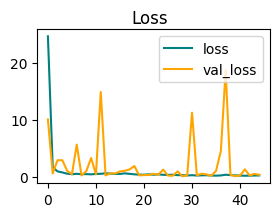

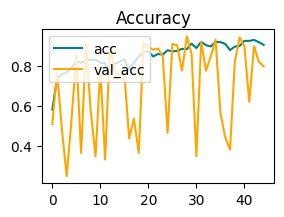

Fold Training Time: 0 hour(s) and 3 mins
Precision: 95.50561904907227  -  Recall: 94.44444179534912
Accuracy: 94.9999988079071
F1Score-P: 93.33333587646484
F1Score-R: 96.66666412353516
F1Score-V: 95.0
[neptune] [info   ] Shutting down background jobs, please wait a moment...
[neptune] [info   ] Done!
[neptune] [info   ] Neptune initialized. Open in the app: offline/9a966620-7559-4379-867d-78605da67949
Epoch 1/45
156/158 [============================>.] - ETA: 0s - loss: 18.8977 - accuracy: 0.6386
Epoch 1: val_loss improved from inf to 2.61075, saving model to /content/MODEL/Model 3CLS-NB-4.1.2/FOLD-2
158/158 [==============================] - 13s 64ms/step - loss: 18.7329 - accuracy: 0.6389 - val_loss: 2.6107 - val_accuracy: 0.5667 - lr: 0.0015
Epoch 2/45
156/158 [============================>.] - ETA: 0s - loss: 1.6777 - accuracy: 0.7356
Epoch 2: val_loss did not improve from 2.61075
158/158 [==============================] - 4s 25ms/step - loss: 1.6745 - accuracy: 0.7365 - val_loss: 

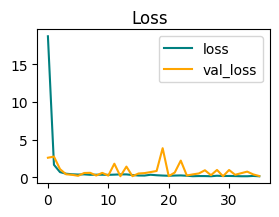

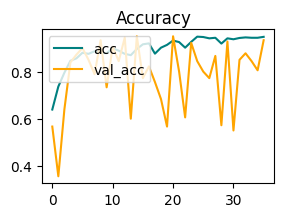

Fold Training Time: 0 hour(s) and 3 mins
Precision: 96.55172228813171  -  Recall: 93.33333373069763
Accuracy: 94.44444179534912
F1Score-P: 94.48818969726562
F1Score-R: 92.17391967773438
F1Score-V: 96.61016845703125
[neptune] [info   ] Shutting down background jobs, please wait a moment...
[neptune] [info   ] Done!
[neptune] [info   ] Neptune initialized. Open in the app: offline/6bf40dde-2807-4b60-a96a-63d64a0afce1
Epoch 1/45
157/158 [============================>.] - ETA: 0s - loss: 26.4344 - accuracy: 0.6019
Epoch 1: val_loss improved from inf to 7.49281, saving model to /content/MODEL/Model 3CLS-NB-4.1.2/FOLD-3
158/158 [==============================] - 13s 61ms/step - loss: 26.3580 - accuracy: 0.6024 - val_loss: 7.4928 - val_accuracy: 0.4333 - lr: 0.0015
Epoch 2/45
158/158 [==============================] - ETA: 0s - loss: 1.9737 - accuracy: 0.6548
Epoch 2: val_loss improved from 7.49281 to 0.76500, saving model to /content/MODEL/Model 3CLS-NB-4.1.2/FOLD-3
158/158 [================

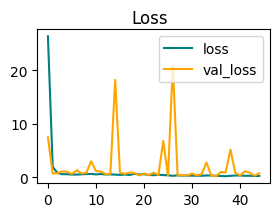

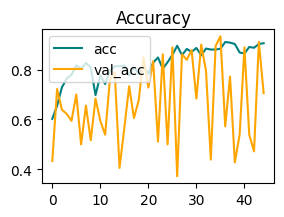

Fold Training Time: 0 hour(s) and 3 mins
Precision: 95.4023003578186  -  Recall: 92.22221970558167
Accuracy: 93.33333373069763
F1Score-P: 94.21487426757812
F1Score-R: 92.17391967773438
F1Score-V: 93.54837799072266
[neptune] [info   ] Shutting down background jobs, please wait a moment...
[neptune] [info   ] Done!
[neptune] [info   ] Neptune initialized. Open in the app: offline/cb54546a-7f29-4e32-926e-264e4cf10999
Epoch 1/45
156/158 [============================>.] - ETA: 0s - loss: 23.9115 - accuracy: 0.5409
Epoch 1: val_loss improved from inf to 2.37102, saving model to /content/MODEL/Model 3CLS-NB-4.1.2/FOLD-4
158/158 [==============================] - 13s 61ms/step - loss: 23.7294 - accuracy: 0.5389 - val_loss: 2.3710 - val_accuracy: 0.5444 - lr: 0.0015
Epoch 2/45
158/158 [==============================] - ETA: 0s - loss: 1.7655 - accuracy: 0.6579
Epoch 2: val_loss improved from 2.37102 to 1.20232, saving model to /content/MODEL/Model 3CLS-NB-4.1.2/FOLD-4
158/158 [=================

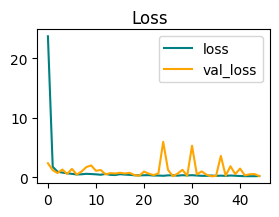

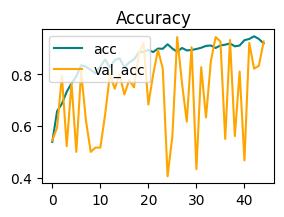

Fold Training Time: 0 hour(s) and 3 mins
Precision: 96.51162624359131  -  Recall: 92.22221970558167
Accuracy: 94.44444179534912
F1Score-P: 92.17391967773438
F1Score-R: 94.4000015258789
F1Score-V: 96.66666412353516
[neptune] [info   ] Shutting down background jobs, please wait a moment...
[neptune] [info   ] Done!
[neptune] [info   ] Neptune initialized. Open in the app: offline/c7f070bf-7b87-4a4c-898c-c593d6a5c32a
Epoch 1/45
157/158 [============================>.] - ETA: 0s - loss: 20.9402 - accuracy: 0.7102
Epoch 1: val_loss improved from inf to 1.58867, saving model to /content/MODEL/Model 3CLS-NB-4.1.2/FOLD-5
158/158 [==============================] - 12s 55ms/step - loss: 20.8924 - accuracy: 0.7103 - val_loss: 1.5887 - val_accuracy: 0.8167 - lr: 0.0015
Epoch 2/45
157/158 [============================>.] - ETA: 0s - loss: 1.7254 - accuracy: 0.8073
Epoch 2: val_loss did not improve from 1.58867
158/158 [==============================] - 4s 25ms/step - loss: 1.7241 - accuracy: 0.8063

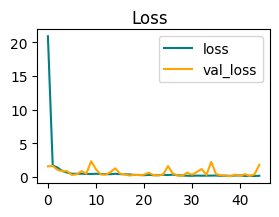

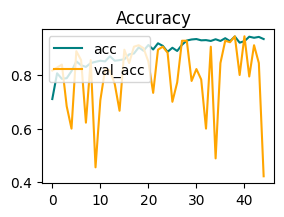

Fold Training Time: 0 hour(s) and 3 mins
Precision: 94.44444179534912  -  Recall: 94.44444179534912
Accuracy: 94.44444179534912
F1Score-P: 92.79999542236328
F1Score-R: 93.10344696044922
F1Score-V: 97.47898864746094
[neptune] [info   ] Shutting down background jobs, please wait a moment...
[neptune] [info   ] Done!
[neptune] [info   ] Neptune initialized. Open in the app: offline/80d647ff-3866-48d4-8fc9-f5207a0fdda3
Epoch 1/45
157/158 [============================>.] - ETA: 0s - loss: 27.8413 - accuracy: 0.5900
Epoch 1: val_loss improved from inf to 5.56783, saving model to /content/MODEL/Model 3CLS-NB-4.1.2/FOLD-6
158/158 [==============================] - 12s 55ms/step - loss: 27.8086 - accuracy: 0.5897 - val_loss: 5.5678 - val_accuracy: 0.4889 - lr: 0.0015
Epoch 2/45
156/158 [============================>.] - ETA: 0s - loss: 2.8244 - accuracy: 0.7316
Epoch 2: val_loss improved from 5.56783 to 0.69644, saving model to /content/MODEL/Model 3CLS-NB-4.1.2/FOLD-6
158/158 [================

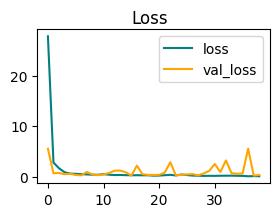

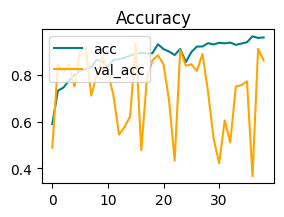

Fold Training Time: 0 hour(s) and 3 mins
Precision: 94.85714435577393  -  Recall: 92.22221970558167
Accuracy: 93.33333373069763
F1Score-P: 93.54837799072266
F1Score-R: 90.26548767089844
F1Score-V: 95.93496704101562
[neptune] [info   ] Shutting down background jobs, please wait a moment...
[neptune] [info   ] Done!
[neptune] [info   ] Neptune initialized. Open in the app: offline/03d1e1ee-a722-44e2-9c5f-707656e92011
Epoch 1/45
157/158 [============================>.] - ETA: 0s - loss: 29.0649 - accuracy: 0.5446
Epoch 1: val_loss improved from inf to 11.43496, saving model to /content/MODEL/Model 3CLS-NB-4.1.2/FOLD-7
158/158 [==============================] - 13s 59ms/step - loss: 28.9873 - accuracy: 0.5444 - val_loss: 11.4350 - val_accuracy: 0.3333 - lr: 0.0015
Epoch 2/45
157/158 [============================>.] - ETA: 0s - loss: 1.2575 - accuracy: 0.6162
Epoch 2: val_loss improved from 11.43496 to 0.85889, saving model to /content/MODEL/Model 3CLS-NB-4.1.2/FOLD-7
158/158 [=============

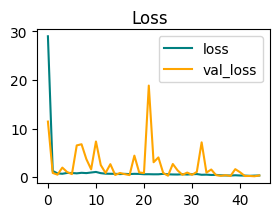

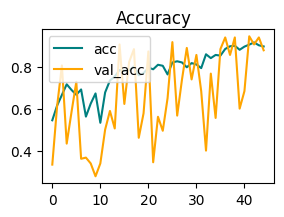

Fold Training Time: 0 hour(s) and 3 mins
Precision: 94.85714435577393  -  Recall: 92.22221970558167
Accuracy: 93.88889074325562
F1Score-P: 92.79999542236328
F1Score-R: 93.22034454345703
F1Score-V: 95.72649383544922
[neptune] [info   ] Shutting down background jobs, please wait a moment...
[neptune] [info   ] Done!
Total Training Time: 0 hour(s) and 30 mins


In [21]:
params = {
    "lr": 0.0015,
    "epochs": 45,
    "batch_size": 8}

precisions = []
recalls = []
accuracies = []
f1_plant = []
f1_road = []
f1_vcl = []

with tf.device('/gpu:0'):
    counter = 0
    start = perf_counter()
    for train, test in kfold.split(train_x, train_y):
        start_fold = perf_counter()

        run = neptune.init_run(
            name= f"{model_name}-FOLD_{counter}",
            project=project_name,
            mode="offline",     # To prevent issue when internet sucks. Just manually sync it
            )  # your credentials

        run["parameters"] = params


        model = make_model(params)
        cat_y = tf.keras.utils.to_categorical(train_y)

        train_dataset = tf.data.Dataset.from_tensor_slices((train_x[train], cat_y[train]))
        train_fold = train_dataset.shuffle(buffer_size=train_dataset.cardinality(), seed=1).batch(params['batch_size'])

        test_dataset = tf.data.Dataset.from_tensor_slices((train_x[test], cat_y[test]))
        test_fold = test_dataset.shuffle(buffer_size=test_dataset.cardinality(), seed=1).batch(params['batch_size'])

        hist = model.fit(train_fold,
                         validation_data=test_fold,
                         batch_size=params['batch_size'],
                         epochs=params['epochs'],
                         verbose=1,
                         callbacks=create_callbacks(counter))
        end_fold = perf_counter()

        # PLOTTING ==================================================
        run["fig-train_loss"].upload(plot_loss(hist))
        run["fig-train_acc"].upload(plot_acc(hist))

        # EVALUATING ==================================================
        model = tf.keras.models.load_model(checkpoint_path + str(counter))

        pre = Precision()
        rec = Recall()
        c_acc = CategoricalAccuracy()
        f1_score = F1Score()
        for batch in test_fold.as_numpy_iterator():
            X, y = batch
            yhat = model.predict(X, verbose=0)
            pre.update_state(y, yhat)
            rec.update_state(y, yhat)
            c_acc.update_state(y, yhat)
            f1_score.update_state(y, yhat)


        precisions.append(pre.result().numpy() * 100)
        recalls.append(rec.result().numpy() * 100)
        accuracies.append(c_acc.result().numpy() * 100)
        f1_s = f1_score.result().numpy() * 100

        f1_plant.append(f1_s[0])
        f1_vcl.append(f1_s[1])
        f1_road.append(f1_s[2])

        run["eval/ACC/"] = accuracies[counter]
        run["eval/REC/"] = recalls[counter]
        run["eval/PRE/"] = precisions[counter]
        run["eval/F1-P"] = f1_plant[counter]
        run["eval/F1-R"] = f1_road[counter]
        run["eval/F1-V"] = f1_vcl[counter]

        # SAVE MODEL TO NEPTUNE AI =======================================
        model_save_path = f'{checkpoint_path}{counter}/{model_name}-FOLD-{counter}.keras'
        model.save(model_save_path)
        run['checkpoint/model'].upload(model_save_path)

        # PRINTING RESULTS ===========================================
        print(f'Fold Training Time: {math.floor((end_fold-start_fold)/3600) } hour(s) and {math.floor((end_fold-start_fold)/60)%60} mins')
        print(f'Precision: {precisions[counter]}  -  Recall: {recalls[counter]}')
        print(f'Accuracy: {accuracies[counter]}')
        print(f'F1Score-P: {f1_plant[counter]}')
        print(f'F1Score-R: {f1_road[counter]}')
        print(f'F1Score-V: {f1_vcl[counter]}')

        run.stop()

        counter += 1

    end = perf_counter()
    print(f'Total Training Time: {math.floor((end-start)/3600) } hour(s) and {math.floor((end-start)/60)%60} mins')

In [22]:
print(f"""
Avg Accuracy: {avg_rate(accuracies)}
Avg Precision: {avg_rate(precisions)}
Avg Recall: {avg_rate(recalls)}
Avg F1-Score-P: {avg_rate(f1_plant)}
Avg F1-Score-R: {avg_rate(f1_road)}
Avg F1-Score-V: {avg_rate(f1_vcl)}
""")


Avg Accuracy: 94.58333253860474
Avg Precision: 95.94441056251526
Avg Recall: 93.4027761220932
Avg F1-Score-P: 93.96150302886963
Avg F1-Score-R: 93.67995929718018
Avg F1-Score-V: 96.06582927703857



In [23]:
run = neptune.init_run(
            name= f"{model_name}-AVG",
            project=project_name,
            mode="offline",     # To prevent issue when internet sucks. Just manually sync it
            )

run["eval/PRE/"] = avg_rate(precisions)
run["eval/REC/"] = avg_rate(recalls)
run["eval/ACC/"] = avg_rate(accuracies)
run["eval/F1-P"] = avg_rate(f1_plant)
run["eval/F1-R"] = avg_rate(f1_road)
run["eval/F1-V"] = avg_rate(f1_vcl)

run.stop()

[neptune] [info   ] Neptune initialized. Open in the app: offline/3d2ab7af-9749-4567-813d-0991736dda7d
[neptune] [info   ] Shutting down background jobs, please wait a moment...
[neptune] [info   ] Done!


In [24]:
os.environ['NEPTUNE_API_TOKEN'] = "eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiJiM2YzNGEwOC1iNmYyLTQ3YTEtYTljNi0xOWNmYWE0ZjZjOTMifQ=="

In [25]:
!neptune sync -p 'New-Thesis/Kaggle-3Cls-No-Building' --offline-only


Offline container 9bd5bbc7-8d86-48f9-8e9d-b1c7335214d5 registered as New-Thesis/Kaggle-3Cls-No-Building/K3NB-25
Synchronising New-Thesis/Kaggle-3Cls-No-Building/K3NB-25
Deleted: /content/.neptune/async/run__9bd5bbc7-8d86-48f9-8e9d-b1c7335214d5__28723__g50eyq7q
Synchronization of run New-Thesis/Kaggle-3Cls-No-Building/K3NB-25 completed.
Offline container 9bd5bbfb-ad93-476c-afd9-e3842d4747c5 registered as New-Thesis/Kaggle-3Cls-No-Building/K3NB-26
Synchronising New-Thesis/Kaggle-3Cls-No-Building/K3NB-26
Deleted: /content/.neptune/async/run__9bd5bbfb-ad93-476c-afd9-e3842d4747c5__28723__5uvrdtk9
Synchronization of run New-Thesis/Kaggle-3Cls-No-Building/K3NB-26 completed.
Offline container 9bd5bbfc-47ed-466b-bbaf-eb578105fcb3 registered as New-Thesis/Kaggle-3Cls-No-Building/K3NB-27
Synchronising New-Thesis/Kaggle-3Cls-No-Building/K3NB-27
Deleted: /content/.neptune/async/run__9bd5bbfc-47ed-466b-bbaf-eb578105fcb3__28723__5wlzeorz
Synchronization of run New-Thesis/Kaggle-3Cls-No-Building/K3NB-

In [26]:
!neptune clear


In [27]:
!rm -r "/content/MODEL/Model 3CLS-NB-4.1.2"

## Extract Model Checkpoint
- Download model from neptune AI
- Upload here
- change path and names and run code

In [ ]:
sm = tf.keras.models.load_model("/content/model.keras")


In [ ]:
FIX-MODEL-NAME

sm.save_weights("./checkpoints/test_model")


In [ ]:
!zip -r test.zip "./checkpoints"